Segmentation techniques of brain images
- get brain images and visualize a sample
- try otsus method
- show it doesnt work for localizing precise regions
- train unet model, evaluate it
- show it works, but not transferable to other regions
- evaluate sam on both regions
- 

In [ ]:
# jupyter automatic reload
%load_ext autoreload
%autoreload 2

# get brain images 
# https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
# info about the dataset at https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md
DS_DIR = "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/neurite_oasis_brain_seg/dataset"
"""
import tarfile
tar = tarfile.open(DS_DIR + "neurite-oasis.2d.v1.0.tar")
tar.extractall(DS_DIR)
tar.close()
"""


'\nimport tarfile\ntar = tarfile.open(DS_DIR + "neurite-oasis.2d.v1.0.tar")\ntar.extractall(DS_DIR)\ntar.close()\n'

In [2]:

import os
os.listdir(DS_DIR + "/OASIS_OAS1_0004_MR1/")
"""
[
 'slice_orig.nii.gz', : original image
 'slice_norm.nii.gz', : normalized image
 'slice_seg4.nii.gz', : segmenation, 4 labels
 'slice_seg24.nii.gz' : segmentation, 24 labels
 ]
"""

"\n[\n 'slice_orig.nii.gz', : original image\n 'slice_norm.nii.gz', : normalized image\n 'slice_seg4.nii.gz', : segmenation, 4 labels\n 'slice_seg24.nii.gz' : segmentation, 24 labels\n ]\n"

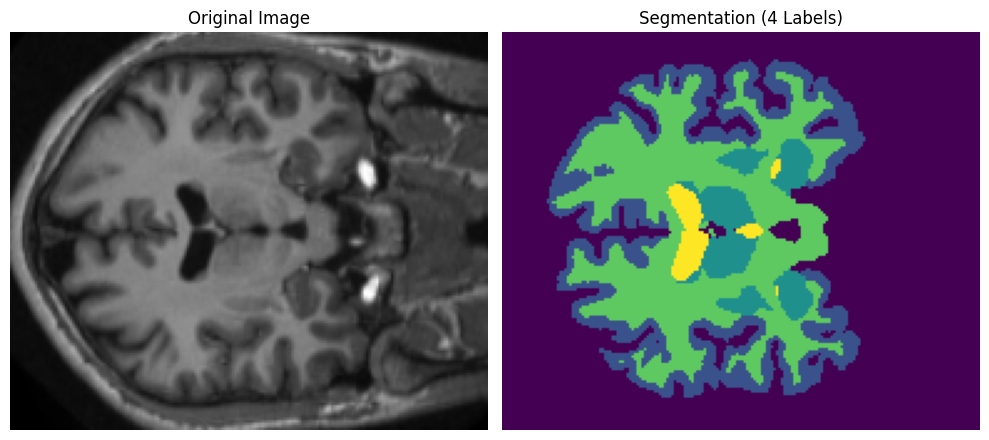

In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Load both images
orig = nib.load(DS_DIR + "/OASIS_OAS1_0004_MR1/slice_orig.nii.gz")
seg4 = nib.load(DS_DIR + "/OASIS_OAS1_0004_MR1/slice_seg4.nii.gz")

# Convert to numpy arrays
orig_img = np.asarray(orig.dataobj)
seg4_img = np.asarray(seg4.dataobj)

# Create side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig_img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(seg4_img, cmap='viridis')
axes[1].set_title('Segmentation (4 Labels)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

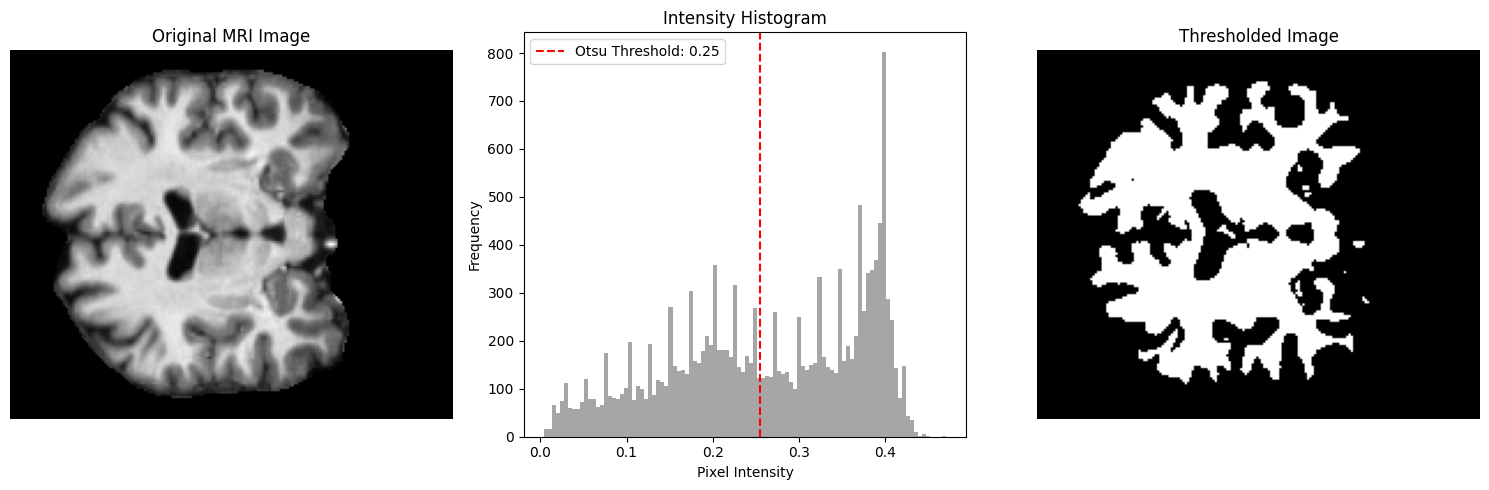

In [4]:

# Load original image
orig = nib.load(DS_DIR + "/OASIS_OAS1_0004_MR1/slice_norm.nii.gz")
orig_img = np.asarray(orig.dataobj)

# Ensure we're working with a 2D array
if len(orig_img.shape) > 2:
    orig_img = np.squeeze(orig_img)

# Remove zero values for histogram
#orig_img = orig_img[orig_img > 0]

# Create figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Display original image
axes[0].imshow(orig_img, cmap='gray')
axes[0].set_title('Original MRI Image')
axes[0].axis('off')

# Plot histogram
axes[1].hist(orig_img[orig_img > 0].ravel(), bins=100, color='gray', alpha=0.7)
axes[1].set_title('Intensity Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')
#ax2.set_ylim(0, 1000)  # Set y-axis limit for better visibility

# Add a vertical line for Otsu's threshold
from skimage.filters import threshold_otsu
otsu_threshold = threshold_otsu(orig_img[orig_img > 0])
axes[1].axvline(x=otsu_threshold, color='r', linestyle='--', 
            label=f'Otsu Threshold: {otsu_threshold:.2f}')
axes[1].legend()

# Display thresholded image
thresholded_img = orig_img > otsu_threshold
axes[2].imshow(thresholded_img, cmap='gray')
axes[2].set_title('Thresholded Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

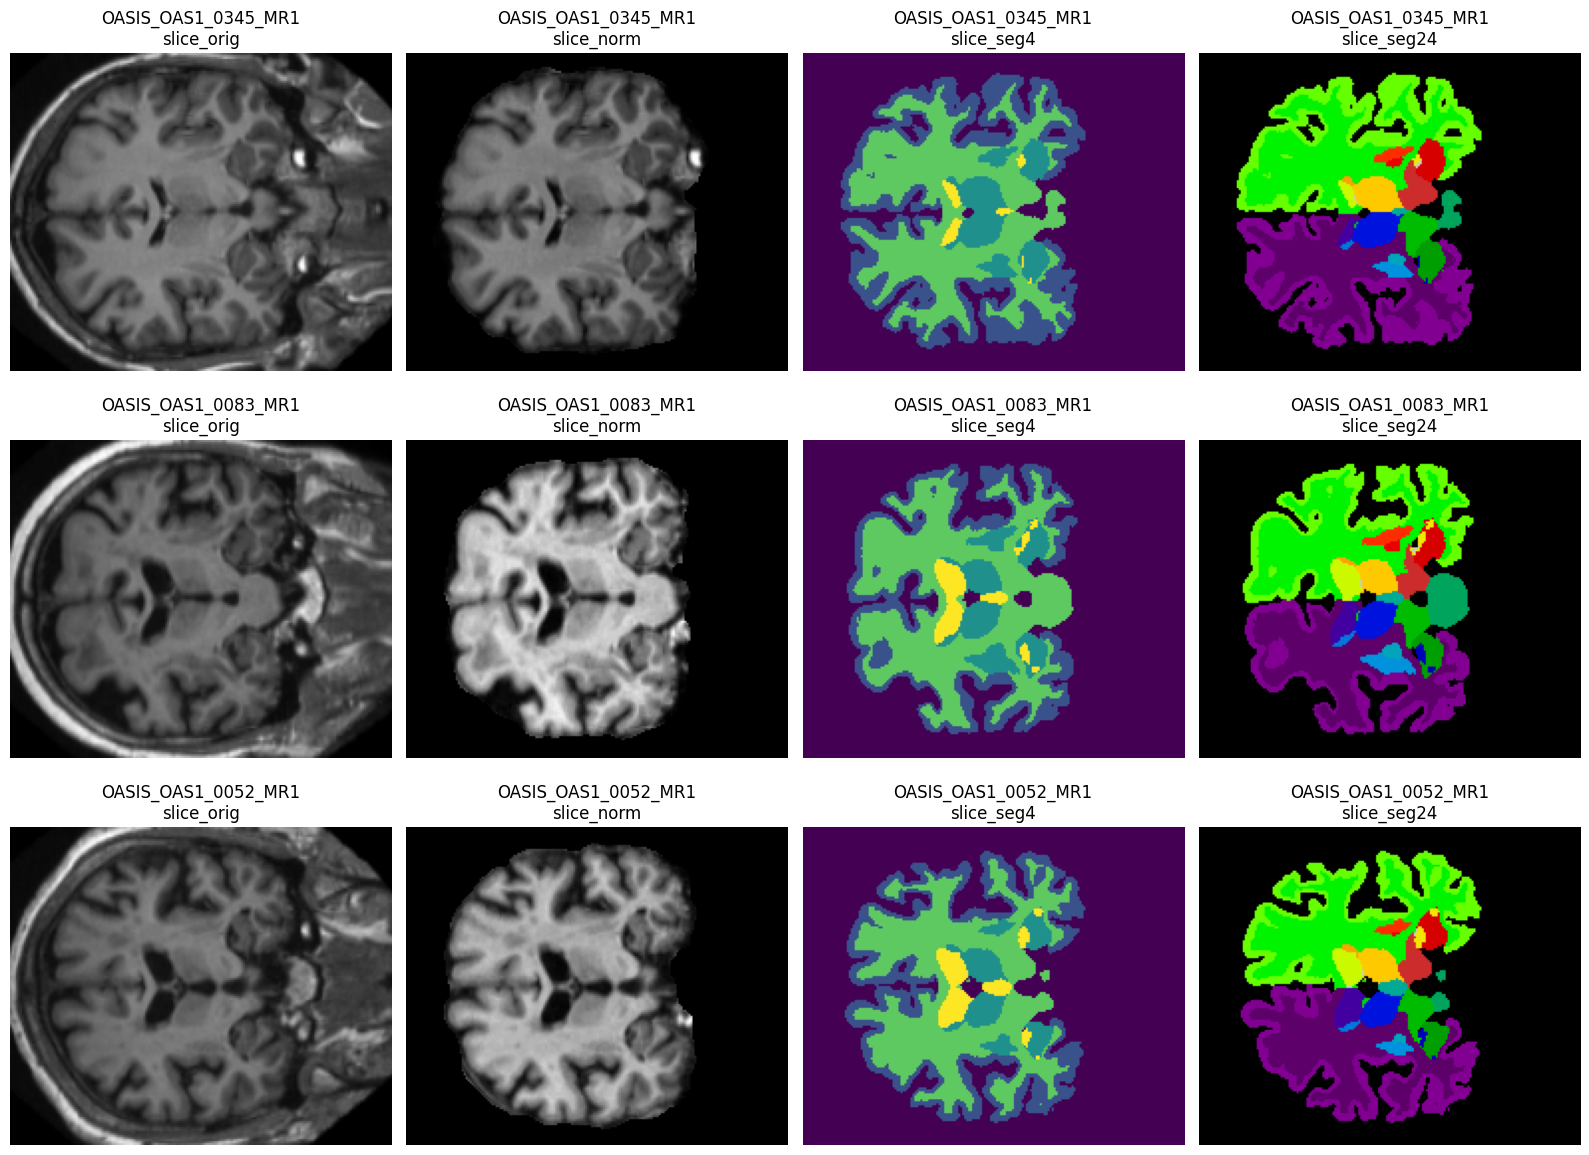

In [5]:
from medical_imagery_journals.helper_functions import display_samples
# Get sample directories (adjust to get the directories you want)
sample_dirs = [d for d in os.listdir(DS_DIR) if d.startswith('OASIS_OAS')]

# Display the samples
display_samples(DS_DIR, sample_dirs, n_rows=3)

Training a U-Net model

In [12]:
# load the dataset, pytorch style
import sys
from cv2 import transform
import torch 

from medical_imagery_journals.helper_functions import BrainSegmentationDataset

sys.path.append("/nfs/norasys/notebooks/camaret/experiments/2dseg")
from config import *
OUTPUT_DIR = "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/neurite_oasis_brain_seg/results"
from data.transforms import JointTransform

# Get all sample directories
all_dirs = [d for d in os.listdir(DS_DIR) 
            if os.path.isdir(os.path.join(DS_DIR, d)) and 
            d.startswith('OASIS_OAS')]

# Create train/val split (80% train, 20% val)
np.random.seed(42)  # For reproducibility
np.random.shuffle(all_dirs)
split_idx = int(len(all_dirs) * 0.8)
train_dirs = all_dirs[:split_idx]
val_dirs = all_dirs[split_idx:]

target_labels = [22]  # Labels for the brain structures we want to segment
transforms = None # JointTransform(prob=AUGMENTATION_PROB)
# Create separate datasets for training and validation
train_dataset = BrainSegmentationDataset(DS_DIR, train_dirs, transform = transforms, target_labels=target_labels)
val_dataset = BrainSegmentationDataset(DS_DIR, val_dirs, target_labels=target_labels)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

print("Sample image shape:", train_dataset[0][0].shape)
print("Sample segmentation shape:", train_dataset[0][0].shape)
print("Sample segmentation labels:", train_dataset[0][1].unique())

Training samples: 331
Validation samples: 83
Sample image shape: torch.Size([1, 160, 192])
Sample segmentation shape: torch.Size([1, 160, 192])
Sample segmentation labels: tensor([ 0., 22.])


In [13]:
import torch.optim as optim

from models.unet import SimpleUNet
from utils.losses import CombinedLoss
from utils.metrics import dice_coefficient, visualize_predictions

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = SimpleUNet(in_chans=IN_CHANNELS, out_chans=OUT_CHANNELS, features=DIMS)
criterion = CombinedLoss(dice_weight=DICE_WEIGHT)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    


Using device: cuda


Epoch 1/50 - Training:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 1/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 37.54it/s]


Epoch 1/50 - Train Loss: 0.2093, Val Loss: 0.0231, Val Dice: 1.6551, Time: 2.10s


Epoch 2/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 52.21it/s]


Epoch 2/50 - Train Loss: -0.1130, Val Loss: -0.2146, Val Dice: 1.8406, Time: 1.88s


Epoch 3/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 52.16it/s]


Epoch 3/50 - Train Loss: -0.2139, Val Loss: -0.3404, Val Dice: 1.8529, Time: 1.86s


Epoch 4/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.08it/s]


Epoch 4/50 - Train Loss: -0.3124, Val Loss: -0.3566, Val Dice: 1.8668, Time: 1.87s


Epoch 5/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 48.71it/s]


Epoch 5/50 - Train Loss: -0.4103, Val Loss: -0.4716, Val Dice: 1.8689, Time: 1.94s


Epoch 6/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.28it/s]


Epoch 6/50 - Train Loss: -0.5091, Val Loss: -0.5990, Val Dice: 1.8694, Time: 1.96s


Epoch 7/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 53.11it/s]


Epoch 7/50 - Train Loss: -0.6087, Val Loss: -0.7128, Val Dice: 1.8724, Time: 1.90s


Epoch 8/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.98it/s]


Epoch 8/50 - Train Loss: -0.7090, Val Loss: -0.7849, Val Dice: 1.8734, Time: 1.89s


Epoch 9/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 49.19it/s]


Epoch 9/50 - Train Loss: -0.8156, Val Loss: -0.8183, Val Dice: 1.8767, Time: 1.92s


Epoch 10/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.47it/s]


Epoch 10/50 - Train Loss: -0.9255, Val Loss: -1.0162, Val Dice: 1.8770, Time: 1.91s


Epoch 11/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 49.01it/s]


Epoch 11/50 - Train Loss: -1.0338, Val Loss: -1.0625, Val Dice: 1.8794, Time: 1.94s


Epoch 12/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 49.98it/s]


Epoch 12/50 - Train Loss: -1.1425, Val Loss: -1.1907, Val Dice: 1.8797, Time: 1.90s


Epoch 13/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 47.79it/s]


Epoch 13/50 - Train Loss: -1.2493, Val Loss: -1.3547, Val Dice: 1.8801, Time: 1.88s


Epoch 14/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.95it/s]


Epoch 14/50 - Train Loss: -1.3549, Val Loss: -1.4489, Val Dice: 1.8814, Time: 1.90s


Epoch 15/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 48.82it/s]


Epoch 15/50 - Train Loss: -1.4543, Val Loss: -1.4855, Val Dice: 1.8790, Time: 1.90s


Epoch 16/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.83it/s]


Epoch 16/50 - Train Loss: -1.5550, Val Loss: -1.6268, Val Dice: 1.8814, Time: 2.02s


Epoch 17/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.96it/s]


Epoch 17/50 - Train Loss: -1.6533, Val Loss: -1.7498, Val Dice: 1.8815, Time: 2.00s


Epoch 18/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 50.57it/s]


Epoch 18/50 - Train Loss: -1.7480, Val Loss: -1.7596, Val Dice: 1.8795, Time: 1.89s


Epoch 19/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 52.06it/s]


Epoch 19/50 - Train Loss: -1.8397, Val Loss: -1.8733, Val Dice: 1.8815, Time: 1.98s


Epoch 20/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 51.96it/s]


Epoch 20/50 - Train Loss: -1.9324, Val Loss: -1.9259, Val Dice: 1.8783, Time: 1.93s


Epoch 21/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 49.62it/s]


Epoch 21/50 - Train Loss: -2.0213, Val Loss: -1.9738, Val Dice: 1.8764, Time: 1.99s


Epoch 22/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 46.76it/s]


Epoch 22/50 - Train Loss: -2.1048, Val Loss: -2.2477, Val Dice: 1.8770, Time: 2.02s


Epoch 23/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 48.56it/s]


Epoch 23/50 - Train Loss: -2.1913, Val Loss: -2.2643, Val Dice: 1.8762, Time: 2.08s


Epoch 24/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 49.06it/s]


Epoch 24/50 - Train Loss: -2.2773, Val Loss: -2.2538, Val Dice: 1.8726, Time: 1.96s


Epoch 25/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 48.86it/s]


Epoch 25/50 - Train Loss: -2.3636, Val Loss: -2.3895, Val Dice: 1.8718, Time: 1.99s


Epoch 26/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 47.21it/s]


Epoch 26/50 - Train Loss: -2.4462, Val Loss: -2.4531, Val Dice: 1.8735, Time: 2.03s


Epoch 27/50 - Validation: 100%|██████████| 21/21 [00:00<00:00, 53.44it/s]


Epoch 27/50 - Train Loss: -2.5296, Val Loss: -2.5670, Val Dice: 1.8755, Time: 2.00s
Early stopping at epoch 27


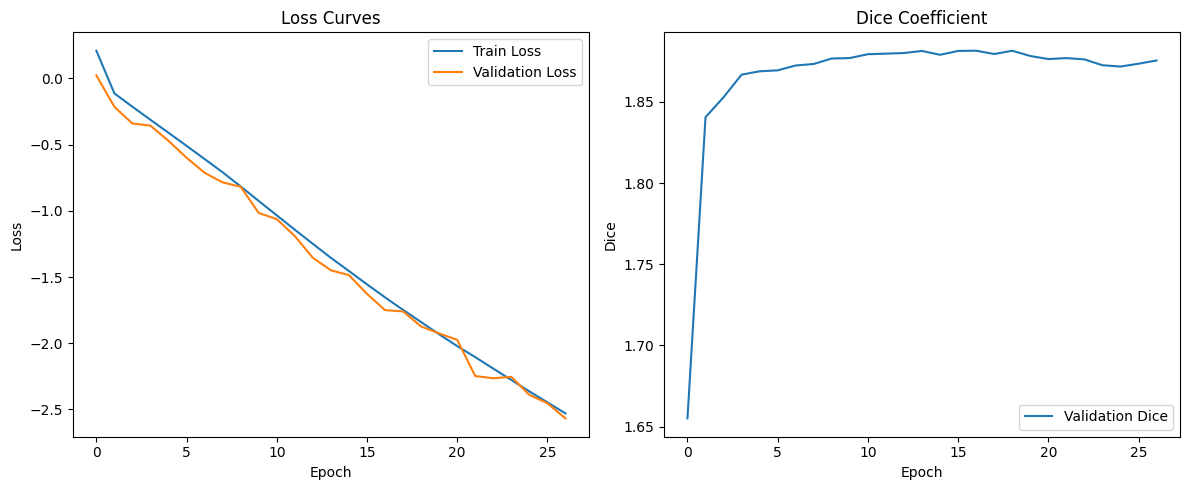

In [14]:
from train import train_model
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        patience=PATIENCE, 
        output_dir=OUTPUT_DIR,
    )


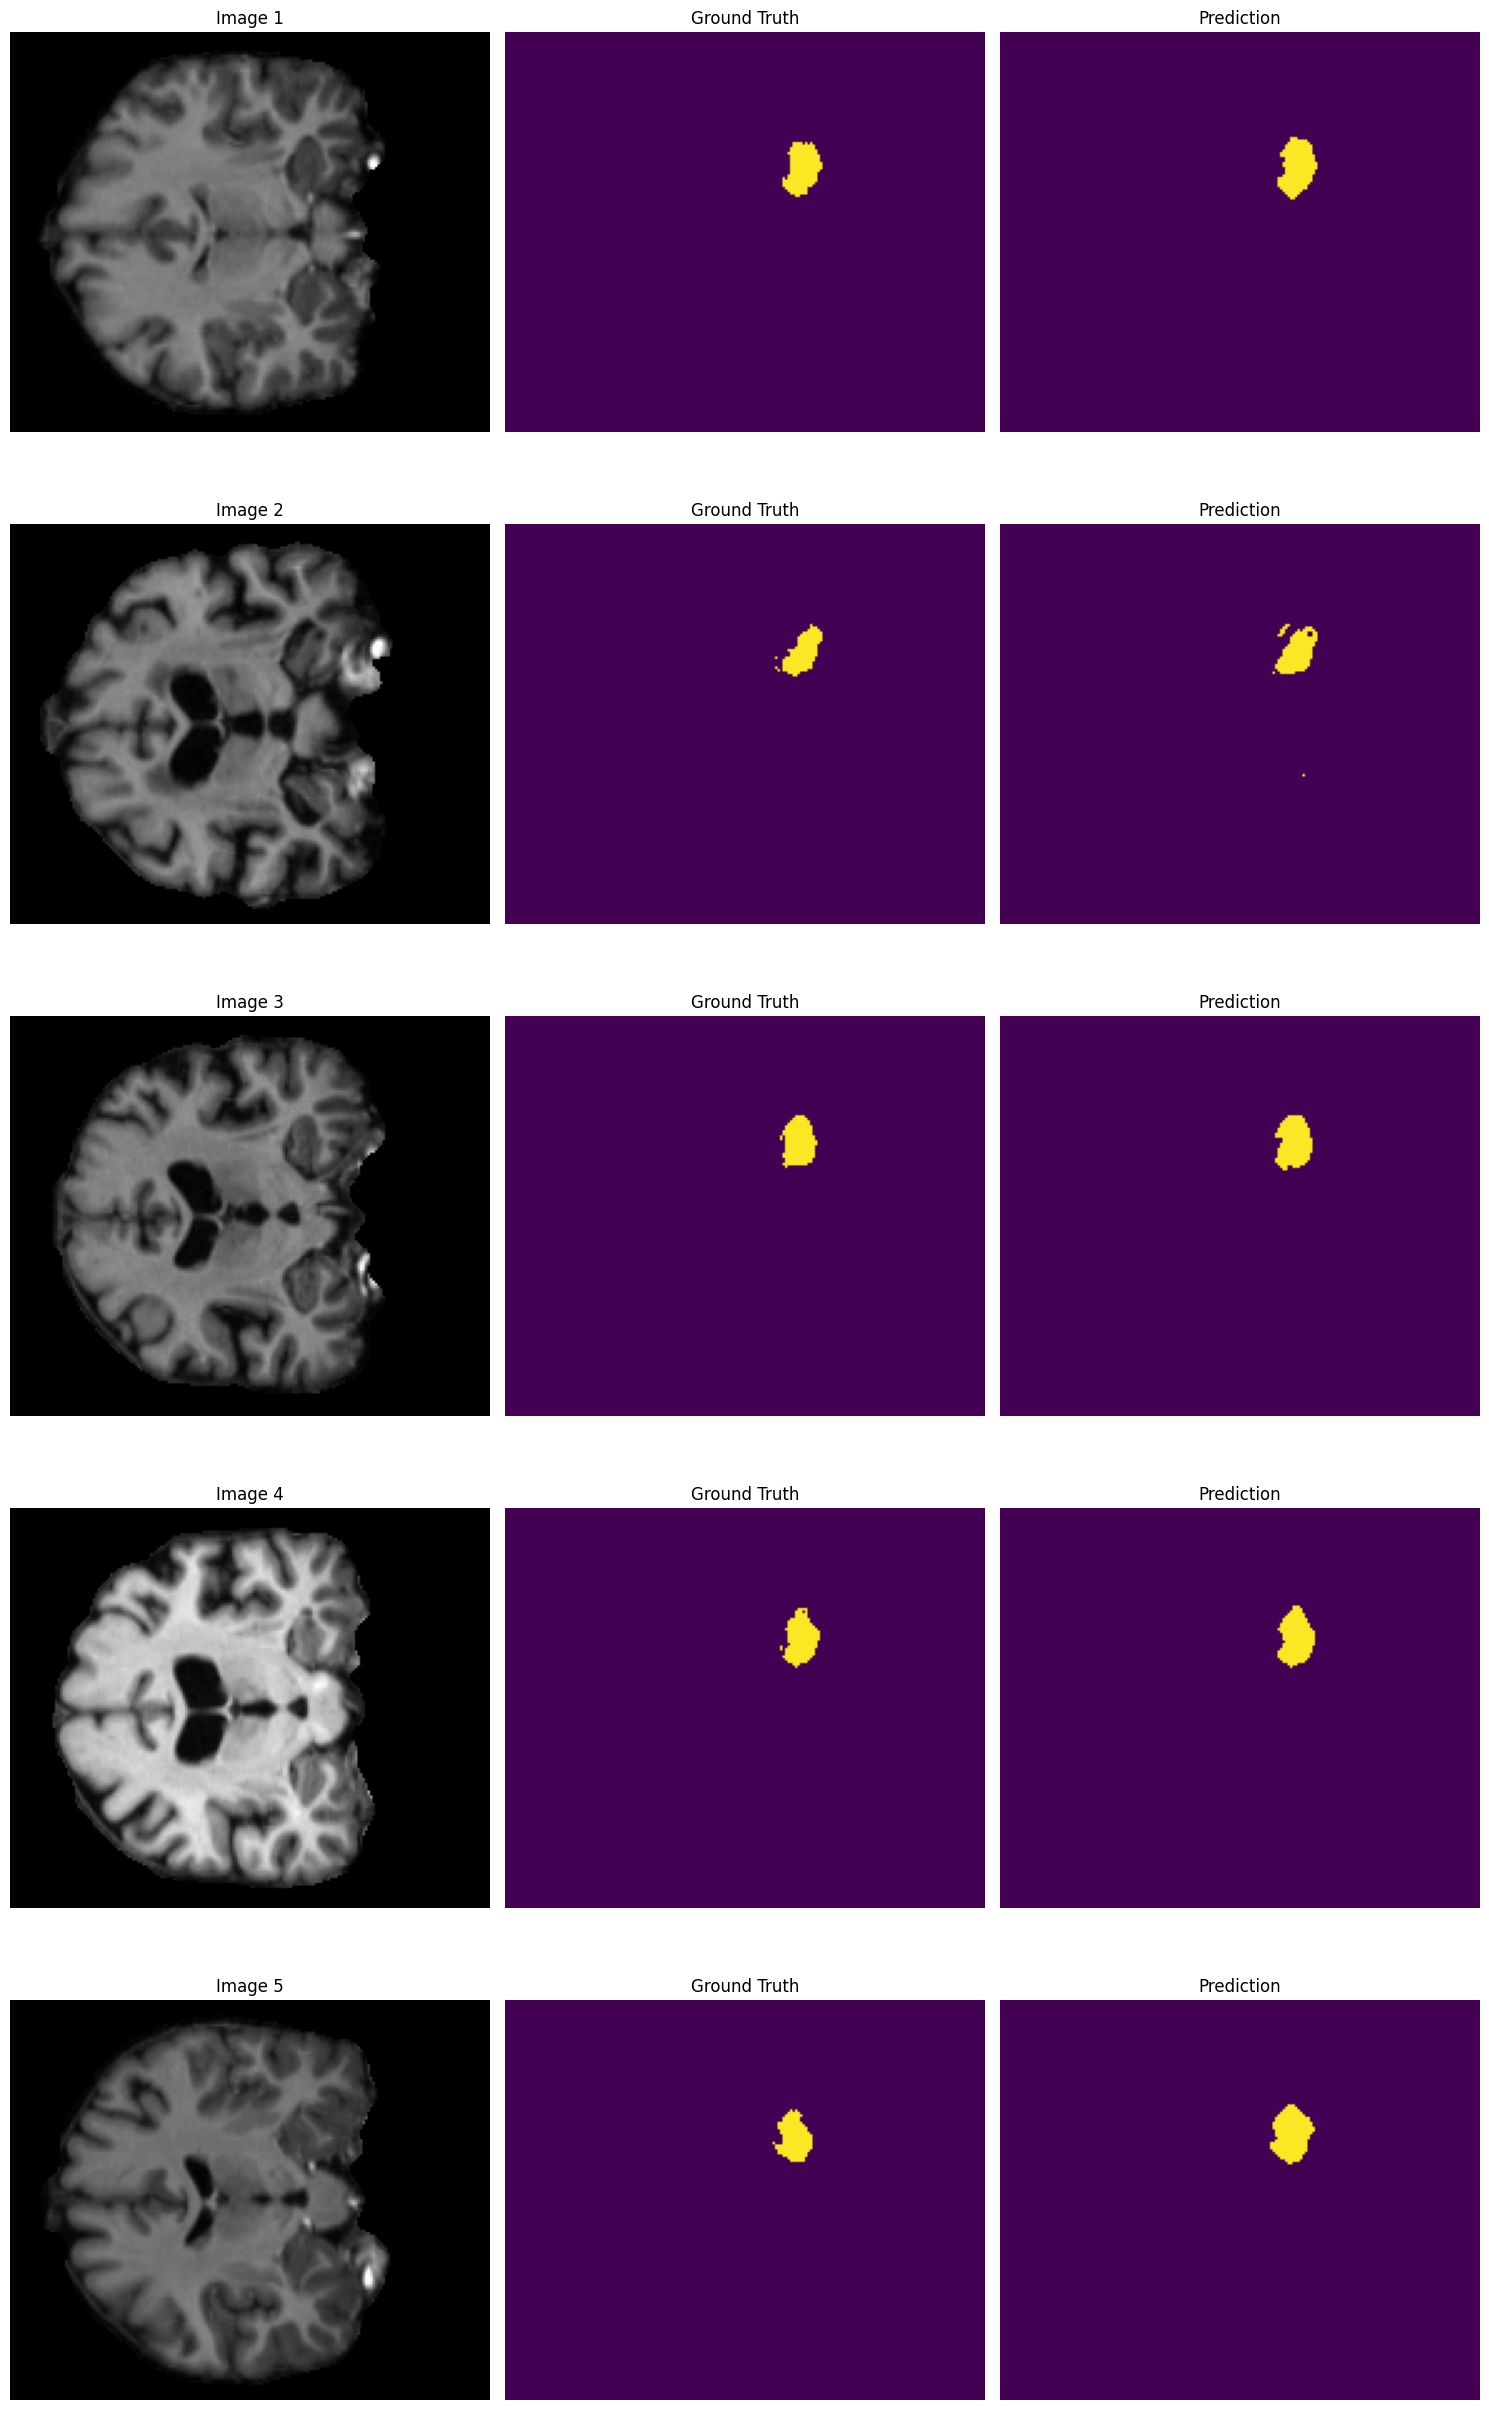

<Figure size 640x480 with 0 Axes>

In [15]:
visualize_predictions(
        model=trained_model,
        dataloader=val_loader,
        device=device,
        num_samples=5,
        output_path=os.path.join(OUTPUT_DIR, 'prediction_results.png')
    )

Use MedSAM 
See https://github.com/bowang-lab/MedSAM

In [ ]:
#%matplotlib widget
from segment_anything import sam_model_registry
MedSAM_CKPT_PATH = "model_checkpoints/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()



Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


Button(description='clear', style=ButtonStyle())

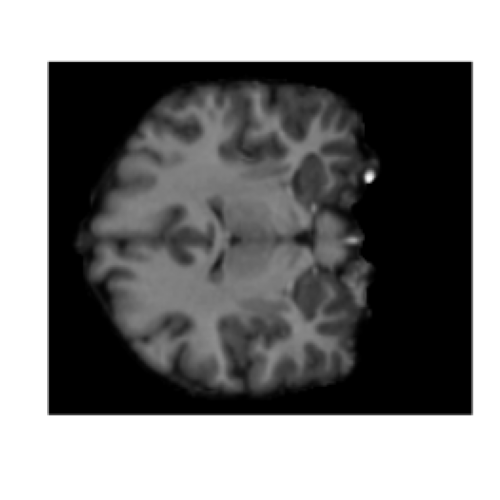

Button(description='save', style=ButtonStyle())

In [ ]:
%matplotlib widget
from medical_imagery_journals.demo import BboxPromptDemo

img = "/nfs/norasys/notebooks/camaret/medical_imagery_journals/brain.png"
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(img)